# Application of Deep Knockoffs for Functional Magnetic Resonance Imaging to Generate Surrogate Data

This notebook describes the pipeline to follow to build Knockoffs from fMRI images. These knockoffs generate surrogate data that is used in non-parametric tests to obtain a Statistical Parametric Map (SPM) of the brain.

First of all, some things to consider:
* fMRI images have been obtained from the Brain Connectome Project and previously preprocessed. 
* 

## Structure
The process is divided into 3 main parts, which consist of:
#### 1. Performing the **General Linear Model (GLM)** on the data
This is the classical method to obtain the SPM, which returns the fitted beta values for $$ y = X\beta$$ where y is the fMRI timecourse and X is the design matrix of the experiment.


#### 2. Generating Knockoffs
Given the data, the algorithm will build a machine to generate surrogate timecourses. 
There are three methods:
    * Gaussian Knockoffs
    * Low Rank Knockoffs
    * Deep Knockoffs
    
    
#### 3. Performing **Non-Parametric Tests**
The GLM is applied to the generated surrogate data to get the beta values and these are used to threshold the true betas using Non-Parametric Tests, which can be:
    * Uncorrected Non-Parametric Test
    * Corrected Non-Parametric Test
    



In [1]:
from implementation import glm, knockoff_class, params
from implementation.load import load_pickle
from implementation.utils import KNOCK_DIR
#import importlib
#importlib.reload(params)
#importlib.reload(knockoff_class)

## 1. GLM

In [2]:
glm.run()

 MOTOR 
Loading data for task MOTOR...
Loaded Data - Shape: (100, 379, 284)
Loaded Task Paradigms - Shape: (100, 284)
Computing GLM for task MOTOR...
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 100 subjects and 379 regions...
Done!
Saving activations and beta values for task MOTOR...
 GAMBLING 
Loading data for task GAMBLING...
Loaded Data - Shape: (100, 379, 253)
Loaded Task Paradigms - Shape: (100, 253)
Computing GLM for task GAMBLING...
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 100 subjects and 379 regions...
Done!
Saving activations and beta values for task GAMBLING...
 RELATIONAL 
Loading data for task RELATIONAL...
Loaded Data - Shape: (100, 379, 232)
Loaded Task Paradigms - Shape: (100, 232)
Computing GLM for task RELATIONAL...
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 100 subjects and 379 regions...
Done!
Saving activations and beta values for task RELATIONAL...
 SOCIAL 
Loading data for task SOCIAL...
Loa

## 2. Building Knockoffs

In [3]:
task = 'MOTOR'
subject = 1

### a) Gaussian Knockoffs

Loaded Data - Shape: (100, 379, 284)
Divided 379 variables into 154 groups.
Divided 379 variables into 154 groups.
Size of largest groups: 37
Mean groups size: 2.461038961038961
Eigenvalue for Sigma Hat, Min: -4.006705455559442e-15
Eigenvalue for Sigma Hat Representatives, Min: 0.04360734588940268
Original for Correlations, Max: 0.8022580778679829
Representatives for Correlations, Max: 0.4585931438028127
Average absolute pairwise correlation: 0.859.


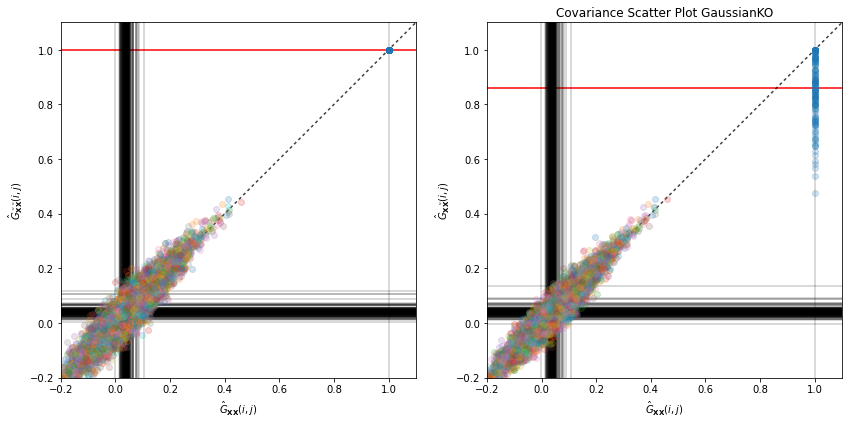

                               Value                                     \
                               count        mean        std         min   
Method     Metric     Swap                                                
GaussianKO Covariance full     100.0  233.655337  12.187297  204.736409   
                      partial  100.0  258.453543  12.658473  227.747630   
                      self     100.0    0.858866   0.001234    0.855176   
           Energy     full     100.0    0.307688   0.005407    0.294844   
                      partial  100.0    0.308740   0.005237    0.296591   
           KNN        full     100.0    0.650035   0.020273    0.584507   
                      partial  100.0    0.662359   0.021636    0.605634   
           MMD        full     100.0   -0.001909   0.000316   -0.002703   
                      partial  100.0   -0.001793   0.000323   -0.002612   

                                                                               
                   

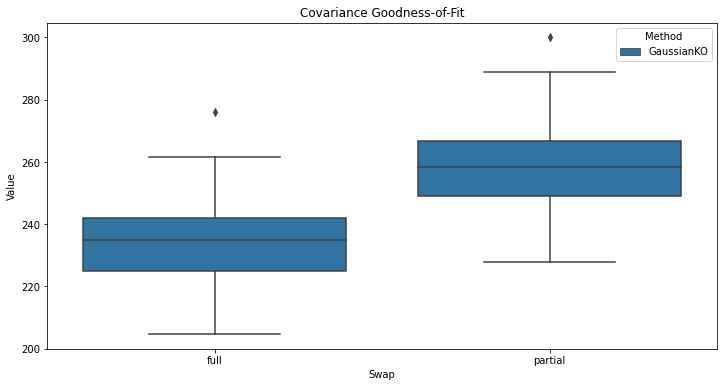

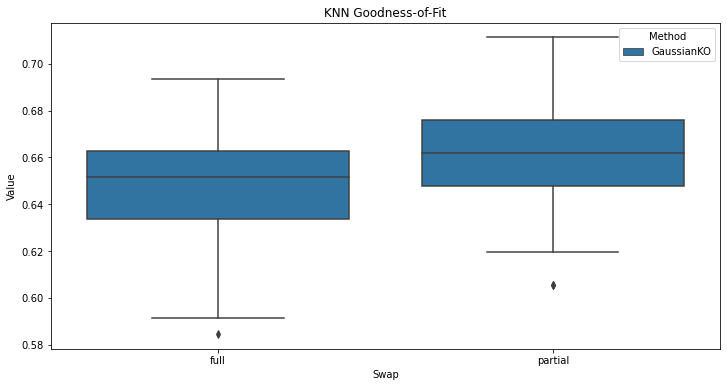

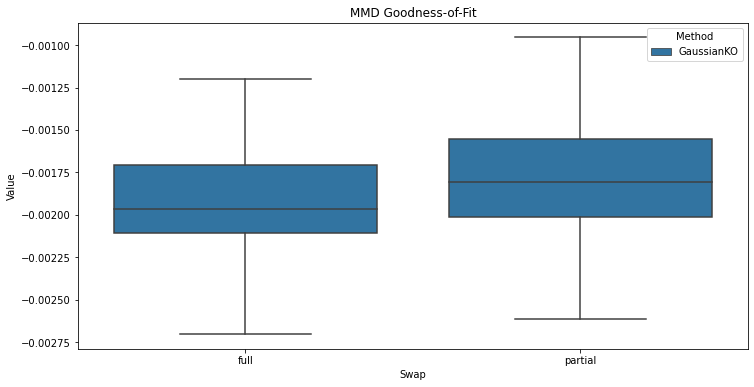

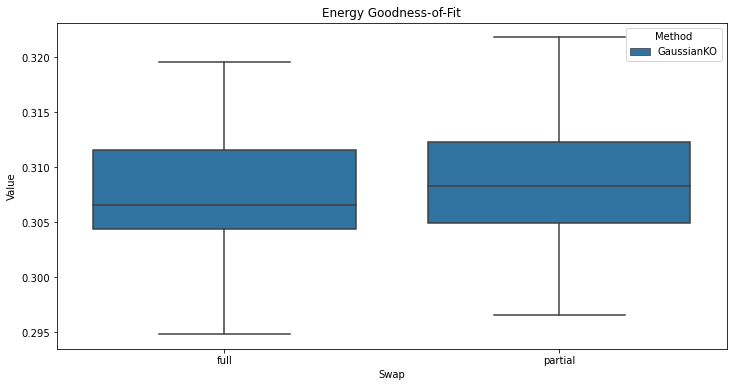

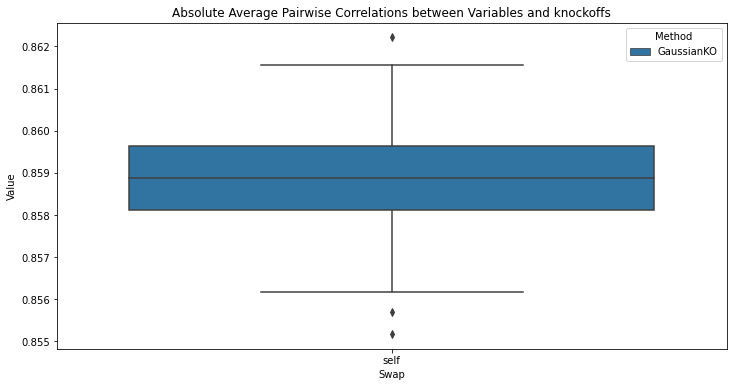

In [4]:
gaussian = knockoff_class.GaussianKnockOff(task, subject)  

gaussian.load_fmri()

# Pre-processing the data: clustering to avoid correlations
gaussian.pre_process(max_corr=.3)

# Training the machine to build second-order knockoffs
_ = gaussian.fit() 

# Plotting diagnostics to show the performance of the knockoffs
gaussian.diagnostics()

In [5]:
# Building the knockoffs: the resulting data matrix will be of shape (real+knockoff, timepoints, regions),
# with (0,:,:) containing the real beta value and (1:, :, :) containing the knockoffs
data_gaussian = gaussian.transform()
print(data_gaussian.shape)

(101, 284, 379)


### b) Low Rank Knockoffs

Loaded Data - Shape: (100, 379, 284)


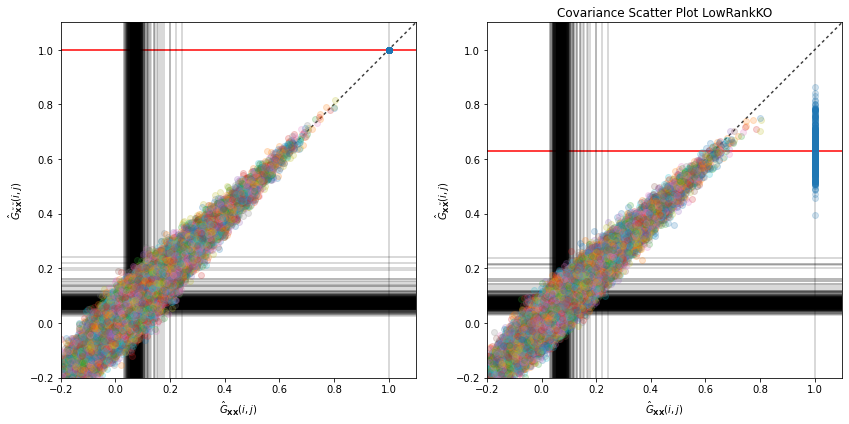

                              Value                                        \
                              count         mean         std          min   
Method    Metric     Swap                                                   
LowRankKO Covariance full     100.0  4047.483376  175.525860  3562.611345   
                     partial  100.0  4599.405889  170.914352  4097.289027   
                     self     100.0     0.626060    0.001487     0.621460   
          Energy     full     100.0     0.578804    0.013733     0.547632   
                     partial  100.0     0.584661    0.013923     0.550915   
          KNN        full     100.0     0.845775    0.015999     0.813380   
                     partial  100.0     0.874225    0.015748     0.834507   
          MMD        full     100.0     0.002696    0.000504     0.001608   
                     partial  100.0     0.003111    0.000517     0.001920   

                                                                     \
    

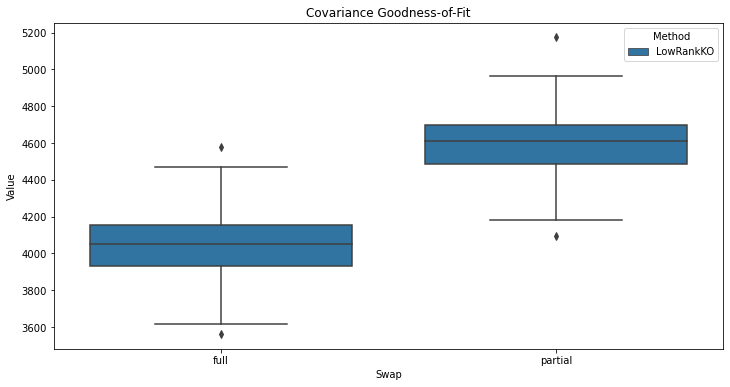

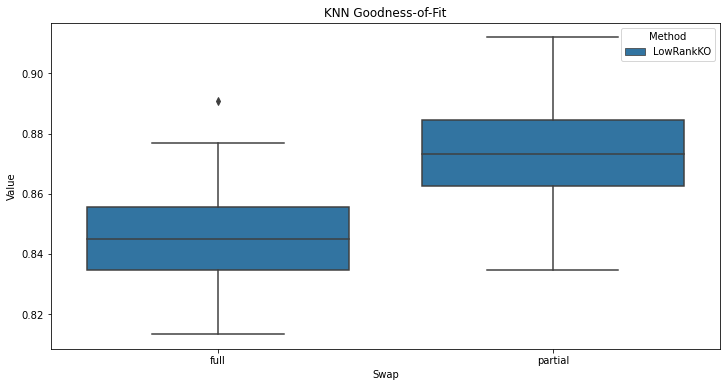

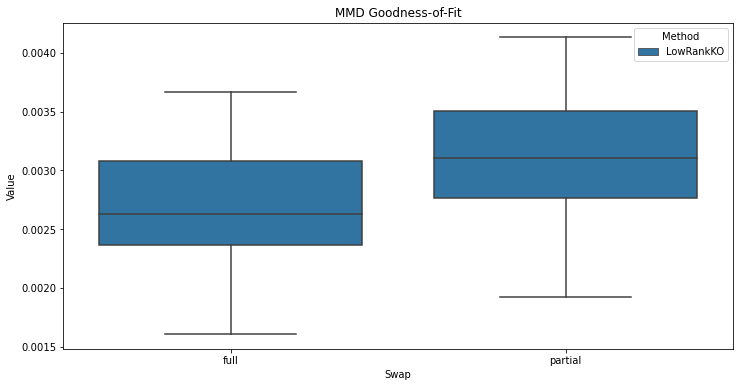

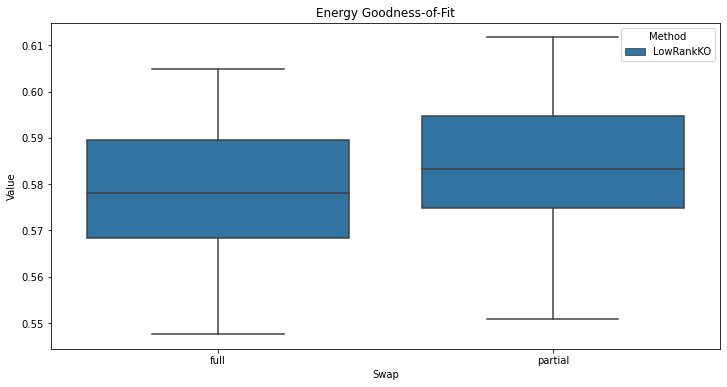

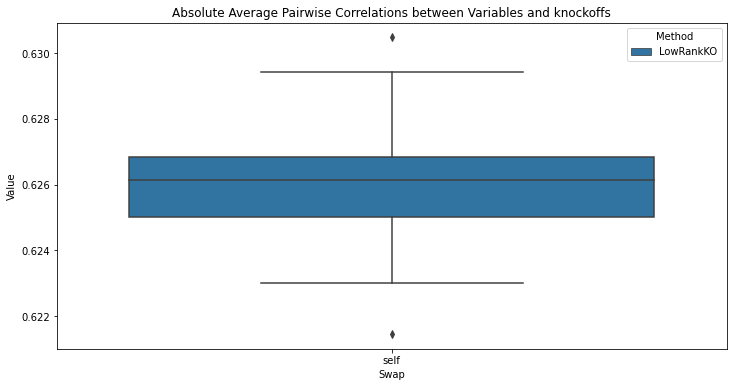

In [6]:
lowrank = knockoff_class.LowRankKnockOff(task, subject)  

lowrank.load_fmri()

# Training the machine to build low-ranked knockoffs
_ = lowrank.fit(rank=120) 

# Plotting diagnostics to show the performance of the knockoffs
lowrank.diagnostics()

In [7]:
# Building the knockoffs: the resulting data matrix will be of shape (real+knockoff, timepoints, regions),
# with (0,:,:) containing the real beta value and (1:, :, :) containing the knockoffs
data_lowrank = lowrank.transform()
print(data_lowrank.shape)

(101, 284, 379)


### c) Deep Knockoffs

Loaded Data - Shape: (100, 379, 284)
Divided 379 variables into 154 groups.
Divided 379 variables into 154 groups.
Size of largest groups: 37
Mean groups size: 2.461038961038961
Eigenvalue for Sigma Hat, Min: -4.006705455559442e-15
Eigenvalue for Sigma Hat Representatives, Min: 0.04360734588940268
Original for Correlations, Max: 0.8022580778679829
Representatives for Correlations, Max: 0.4585931438028127
Saving file GaussianKO_tfMRI_tMOTOR_s1_c0.3.pickle
Saving file GaussianKO_mapping_tMOTOR_s1_c0.3.pickle
Average absolute pairwise correlation: 0.859.
Saving file DeepKO_tMOTOR_s1_params
Fitting the knockoff machine...
[   1/   5], Loss: 0.8805, MMD: 0.7358, Cov: 1.196, Decorr: 0.648
[   2/   5], Loss: 0.8312, MMD: 0.7354, Cov: 1.188, Decorr: 0.708
[   3/   5], Loss: 0.8280, MMD: 0.7353, Cov: 1.173, Decorr: 0.735
[   4/   5], Loss: 0.8266, MMD: 0.7350, Cov: 1.196, Decorr: 0.746
[   5/   5], Loss: 0.8250, MMD: 0.7347, Cov: 1.185, Decorr: 0.748


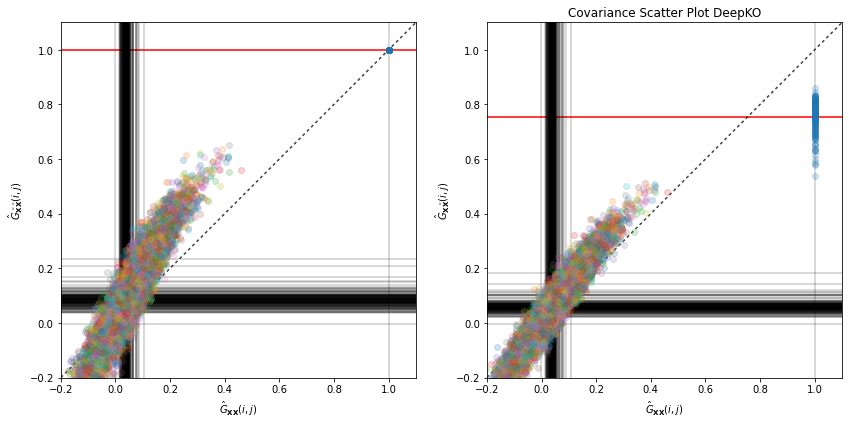

                           Value                                    \
                           count        mean       std         min   
Method Metric     Swap                                               
DeepKO Covariance full     100.0  203.687352  8.136744  182.271020   
                  partial  100.0  202.724227  7.715812  179.715050   
                  self     100.0    0.752292  0.001156    0.748960   
       Energy     full     100.0    0.276339  0.005497    0.260966   
                  partial  100.0    0.277970  0.005343    0.265361   
       KNN        full     100.0    0.712042  0.016969    0.661972   
                  partial  100.0    0.702359  0.019001    0.654930   
       MMD        full     100.0   -0.000408  0.000381   -0.001591   
                  partial  100.0   -0.000302  0.000361   -0.001247   

                                                                           
                                  25%         50%         75%         max  
Method 

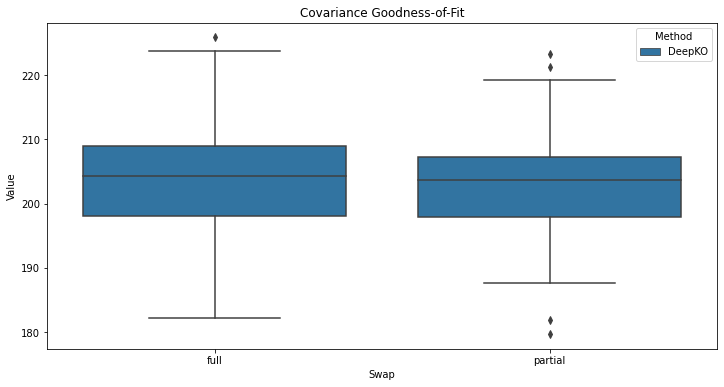

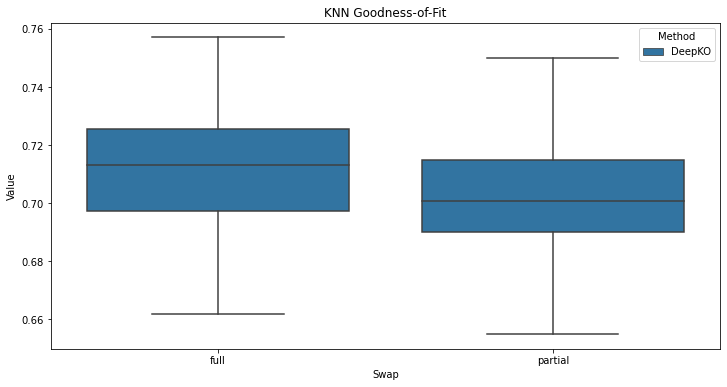

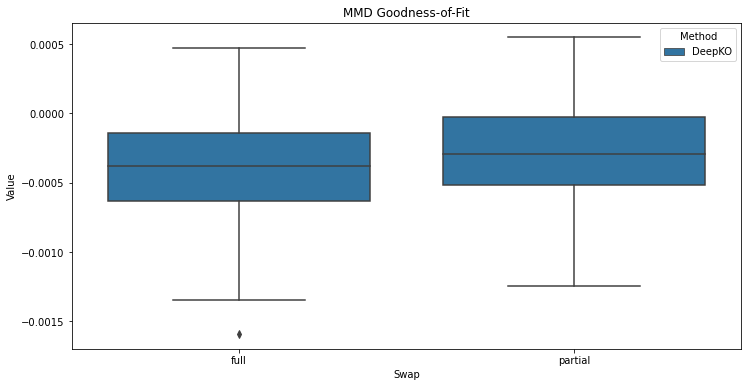

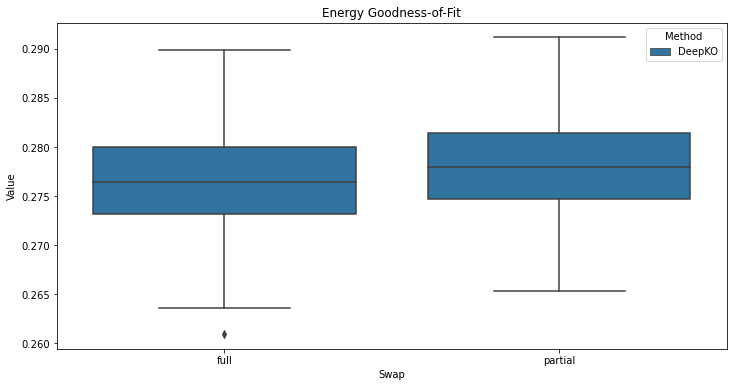

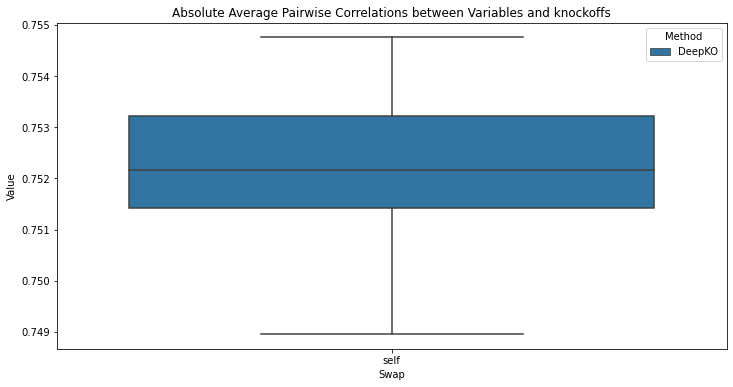

In [8]:
deepko = knockoff_class.DeepKnockOff(task, subject)  

# Pre-processing the data: clustering to avoid correlations
deepko.pre_process(max_corr=.3, save=True)

# Training the machine to build second-order knockoffs. The parameters can be changed at params.py
_ = deepko.fit() 

# Plotting diagnostics to show the performance of the knockoffs
deepko.diagnostics()

In [9]:
# Building the knockoffs: the resulting data matrix will be of shape (real+knockoff, timepoints, regions),
# with (0,:,:) containing the real beta value and (1:, :, :) containing the knockoffs
data_deepko = deepko.transform()
print(data_deepko.shape)

(101, 284, 379)


Loaded Data - Shape: (100, 379, 405)
Divided 379 variables into 172 groups.
Divided 379 variables into 172 groups.
Size of largest groups: 73
Mean groups size: 2.203488372093023
Eigenvalue for Sigma Hat, Min: 9.720730766831024e-05
Eigenvalue for Sigma Hat Representatives, Min: 0.09385948306873601
Original for Correlations, Max: 0.8400040776752845
Representatives for Correlations, Max: 0.4169587905093779
Saving file GaussianKO_tfMRI_tWM_s0_c0.3.pickle
Saving file GaussianKO_mapping_tWM_s0_c0.3.pickle
Average absolute pairwise correlation: 0.731.
Saving file DeepKO_tWM_s0_params
=> loading checkpoint '/Users/janet/EnginyeriaBiomèdica/MSc LIFE SCIENCES ENGINEERING/Machine learning/Project2/machine-learning-cs433-p2/data/output/knockoffs/DeepKO_tWM_s0_checkpoint.pth.tar'
=> loaded checkpoint '/Users/janet/EnginyeriaBiomèdica/MSc LIFE SCIENCES ENGINEERING/Machine learning/Project2/machine-learning-cs433-p2/data/output/knockoffs/DeepKO_tWM_s0_checkpoint.pth.tar' (epoch 1000)


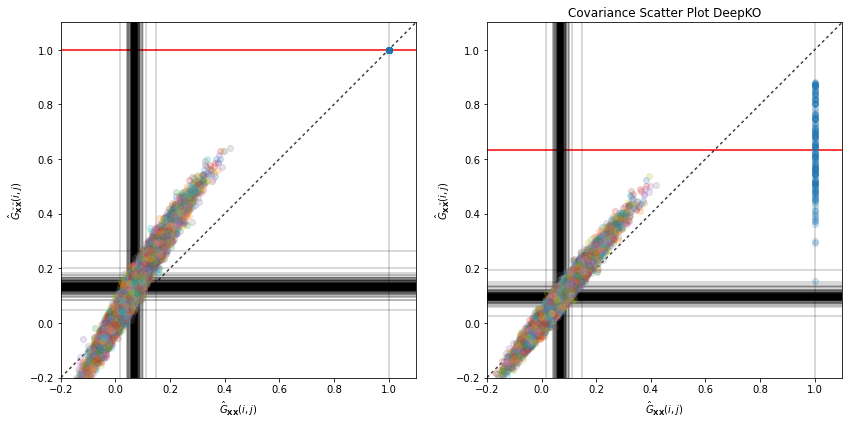

                           Value                                    \
                           count        mean       std         min   
Method Metric     Swap                                               
DeepKO Covariance full     100.0  298.498436  1.475801  294.444522   
                  partial  100.0  315.048319  4.003087  305.734995   
                  self     100.0    0.634994  0.000150    0.634679   
       Energy     full     100.0    0.311090  0.000522    0.309680   
                  partial  100.0    0.317620  0.001241    0.315060   
       KNN        full     100.0    0.372550  0.004894    0.356436   
                  partial  100.0    0.460693  0.015624    0.420792   
       MMD        full     100.0    0.005072  0.000032    0.004995   
                  partial  100.0    0.005627  0.000076    0.005372   

                                                                           
                                  25%         50%         75%         max  
Method 

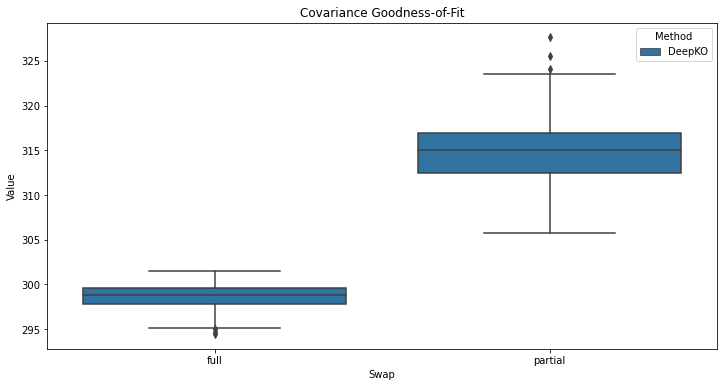

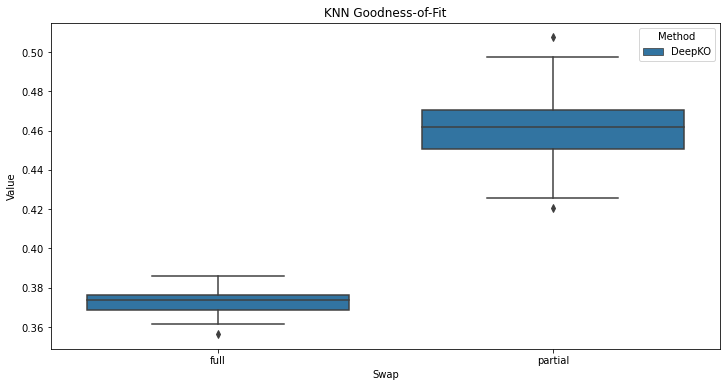

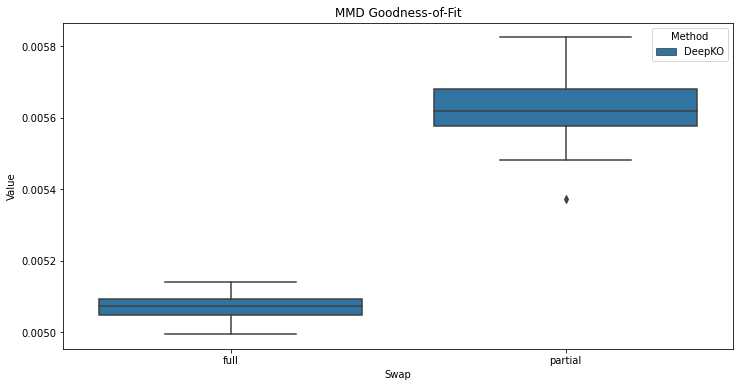

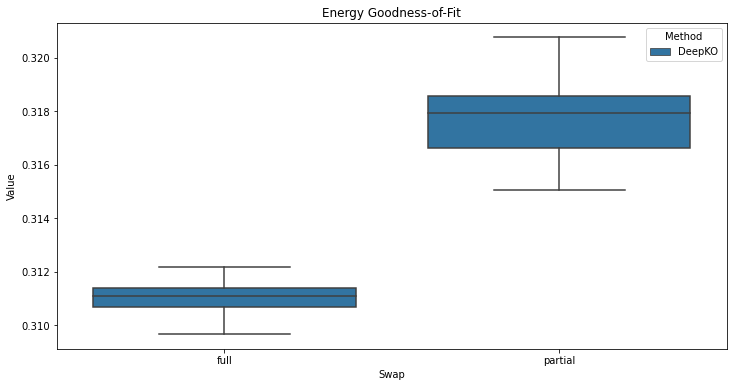

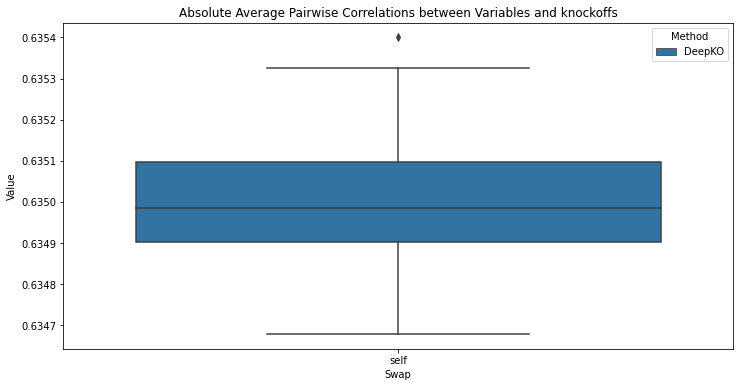

In [10]:
### Alternatively, we can load a previously trained machine


deepko_wm = knockoff_class.DeepKnockOff('WM', 0)
deepko_wm.pre_process(max_corr=.3, save=True)

# Loading previously trained machine
_, x_train = load_pickle(KNOCK_DIR, 'GaussianKO_tfMRI_tWM_s0_c0.3.pickle')
groups, _ = load_pickle(KNOCK_DIR, 'GaussianKO_mapping_tWM_s0_c0.3.pickle')
#params = load_pickle(KNOCK_DIR, 'DeepKO_params_DeepKO_tMOTOR_s10')

deepko_wm.load_x(x_train)
#deepko.load_params(params)
deepko_wm.load_machine()

deepko_wm.diagnostics()

In [11]:
data_deepko_wm = deepko_wm.transform(groups=groups)

deepko_wm_betas = deepko_wm.statistic(data_deepko_wm, save=True)
uncorrected_betas_deepko_wm, corrected_betas_deepko_wm = deepko_wm.threshold(deepko_wm_betas, save=True)


Loaded Task Paradigms - Shape: (100, 405)
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 101 subjects and 379 regions...
Done!
Saving file DeepKO_KObetas_tWM_s0.mat
Performing uncorrected non-parametric test...
Performing corrected non-parametric test...
Saving file DeepKO_uncorrected_betas_tWM_s0.mat
Saving file DeepKO_corrected_betas_tWM_s0.mat


## 3. Non-Parametric tests

In [12]:
# Computing the beta values of the knockoffs
gaussian_betas = gaussian.statistic(data_gaussian, save=True)
lowrank_betas = lowrank.statistic(data_lowrank, save=True)
deepko_betas = deepko.statistic(data_deepko, save=True)


Loaded Task Paradigms - Shape: (100, 284)
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 101 subjects and 379 regions...
Done!
Saving file GaussianKO_KObetas_tMOTOR_s1.mat
Loaded Task Paradigms - Shape: (100, 284)
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 101 subjects and 379 regions...
Done!
Saving file LowRankKO_KObetas_tMOTOR_s1.mat
Loaded Task Paradigms - Shape: (100, 284)
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 101 subjects and 379 regions...
Done!
Saving file DeepKO_KObetas_tMOTOR_s1.mat


In [13]:
# Performing corrected and uncorrected Non-Parametric tests to threshold
uncorrected_betas_gaussian, corrected_betas_gaussian = gaussian.threshold(gaussian_betas, save=True)
uncorrected_betas_lowrank, corrected_betas_lowrank = lowrank.threshold(lowrank_betas, save=True)
uncorrected_betas_deepko, corrected_betas_deepko = deepko.threshold(deepko_betas, save=True)

Performing uncorrected non-parametric test...
Performing corrected non-parametric test...
Saving file GaussianKO_uncorrected_betas_tMOTOR_s1.mat
Saving file GaussianKO_corrected_betas_tMOTOR_s1.mat
Performing uncorrected non-parametric test...
Performing corrected non-parametric test...
Saving file LowRankKO_uncorrected_betas_tMOTOR_s1.mat
Saving file LowRankKO_corrected_betas_tMOTOR_s1.mat
Performing uncorrected non-parametric test...
Performing corrected non-parametric test...
Saving file DeepKO_uncorrected_betas_tMOTOR_s1.mat
Saving file DeepKO_corrected_betas_tMOTOR_s1.mat
